# Project A: Knowledge Distillation for Building Lightweight Deep Learning Models in Visual Classification Tasks

In [1]:
#import tensorflow.compat.v2 as tf
import tensorflow as tf
import tensorflow_datasets as tfds
from typing import Union

#tf.enable_v2_behavior()

builder = tfds.builder('mnist')
BATCH_SIZE = 256
NUM_EPOCHS = 12
NUM_CLASSES = 10  # 10 total classes.

# Data loading

In [2]:
# Load train and test splits.
def preprocess(x):
  image = tf.image.convert_image_dtype(x['image'], tf.float32)
  subclass_labels = tf.one_hot(x['label'], builder.info.features['label'].num_classes)
  return image, subclass_labels


mnist_train = tfds.load('mnist', split='train', shuffle_files=False).cache()
mnist_train = mnist_train.map(preprocess)
mnist_train = mnist_train.shuffle(builder.info.splits['train'].num_examples)
mnist_train = mnist_train.batch(BATCH_SIZE, drop_remainder=True)

mnist_test = tfds.load('mnist', split='test').cache()
mnist_test = mnist_test.map(preprocess).batch(BATCH_SIZE)

# Problem 2: Model creation

In [3]:
#@test {"output": "ignore"}

# Build CNN teacher.
cnn_model = tf.keras.Sequential()

# your code start from here for stpe 2
cnn_model.add(tf.keras.layers.Conv2D(filters = 32,kernel_size = (3,3),
                                     strides=(1, 1),activation ='relu'))
cnn_model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2),strides =(1,1)))
cnn_model.add(tf.keras.layers.Conv2D(filters = 64,kernel_size = (3,3),
                                     strides=(1, 1),activation ='relu'))
cnn_model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2),strides =(2,2)))
cnn_model.add(tf.keras.layers.Flatten())
cnn_model.add(tf.keras.layers.Dropout(0.5))
cnn_model.add(tf.keras.layers.Dense(128,activation = 'relu'))
cnn_model.add(tf.keras.layers.Dropout(0.5))
cnn_model.add(tf.keras.layers.Dense(10))


# Build fully connected student.
def build_student_model():
  fc_model = tf.keras.Sequential()

  # your code start from here for step 2
  fc_model.add(tf.keras.layers.Flatten())
  fc_model.add(tf.keras.layers.Dense(784,activation = 'relu'))
  fc_model.add(tf.keras.layers.Dense(784,activation = 'relu'))
  fc_model.add(tf.keras.layers.Dense(10))
  return fc_model

# Problem 3: Teacher loss function

In [4]:
@tf.function
def compute_teacher_loss(images, labels):
  """Compute subclass knowledge distillation teacher loss for given images
     and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  subclass_logits = cnn_model(images, training=True)

  # Compute cross-entropy loss for subclasses.

  # your code start from here for step 3
  cross_entropy_loss_value = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits( \
          labels, subclass_logits))


  return cross_entropy_loss_value

# Student loss function

In [5]:
#@test {"output": "ignore"}

# Hyperparameters for distillation (need to be tuned).
ALPHA = 0.5 # task balance between cross-entropy and distillation loss
DISTILLATION_TEMPERATURE = 4. #temperature hyperparameter

def distillation_loss(teacher_logits: tf.Tensor, student_logits: tf.Tensor,
                      temperature: Union[float, tf.Tensor]):
  """Compute distillation loss.

  This function computes cross entropy between softened logits and softened
  targets. The resulting loss is scaled by the squared temperature so that
  the gradient magnitude remains approximately constant as the temperature is
  changed. For reference, see Hinton et al., 2014, "Distilling the knowledge in
  a neural network."

  Args:
    teacher_logits: A Tensor of logits provided by the teacher.
    student_logits: A Tensor of logits provided by the student, of the same
      shape as `teacher_logits`.
    temperature: Temperature to use for distillation.

  Returns:
    A scalar Tensor containing the distillation loss.
  """
 # your code start from here for step 3
  soft_targets = tf.nn.softmax(teacher_logits/temperature, axis = -1)

  return tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(
          soft_targets, student_logits / temperature)) * temperature ** 2

def compute_student_loss(images, labels):
  """Compute subclass knowledge distillation student loss for given images
     and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  student_subclass_logits = fc_model(images, training=True)

  # Compute subclass distillation loss between student subclass logits and
  # softened teacher subclass targets probabilities.

  # your code start from here for step 3

  teacher_subclass_logits = cnn_model(images, training=False)
  distillation_loss_value = distillation_loss(teacher_subclass_logits,
                student_subclass_logits, DISTILLATION_TEMPERATURE)

  # Compute cross-entropy loss with hard targets.

  # your code start from here for step 3

  cross_entropy_loss_value = tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(labels, student_subclass_logits))

  return ALPHA*distillation_loss_value + (1 - ALPHA)*cross_entropy_loss_value

# Problem 4: Train and evaluation

In [6]:
@tf.function
def compute_num_correct(model, images, labels):
  """Compute number of correctly classified images in a batch.

  Args:
    model: Instance of tf.keras.Model.
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Number of correctly classified images.
  """
  class_logits = model(images, training=False)
  return tf.reduce_sum(
      tf.cast(tf.math.equal(tf.argmax(class_logits, -1), tf.argmax(labels, -1)),
              tf.float32)), tf.argmax(class_logits, -1), tf.argmax(labels, -1)


def train_and_evaluate(model, compute_loss_fn):
  """Perform training and evaluation for a given model.

  Args:
    model: Instance of tf.keras.Model.
    compute_loss_fn: A function that computes the training loss given the
      images, and labels.
  """

  # your code start from here for step 4
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

  for epoch in range(1, NUM_EPOCHS + 1):
    # Run training.
    print('Epoch {}: '.format(epoch), end='')
    for images, labels in mnist_train:
      with tf.GradientTape() as tape:
         # your code start from here for step 4

        loss_value = compute_loss_fn(images, labels)

      grads = tape.gradient(loss_value, model.trainable_variables)
      optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Run evaluation.
    num_correct = 0
    num_total = builder.info.splits['test'].num_examples
    for images, labels in mnist_test:
      # your code start from here for step 4
      num_correct_batch, pred_digit, true_digit = compute_num_correct(model, images, labels)
      num_correct += num_correct_batch
    print("Class_accuracy: " + '{:.2f}%'.format(
        num_correct / num_total * 100))


# Training models

Problem 5: Tuning Hyperparameters

In [7]:
# your code start from here for step 5
# Teacher training
print('Training and Evaluating Teacher Model')
train_and_evaluate(cnn_model, compute_teacher_loss)

Training and Evaluating Teacher Model
Epoch 1: Class_accuracy: 98.07%
Epoch 2: Class_accuracy: 98.62%
Epoch 3: Class_accuracy: 98.79%
Epoch 4: Class_accuracy: 98.91%
Epoch 5: Class_accuracy: 98.99%
Epoch 6: Class_accuracy: 99.06%
Epoch 7: Class_accuracy: 99.14%
Epoch 8: Class_accuracy: 99.08%
Epoch 9: Class_accuracy: 99.19%
Epoch 10: Class_accuracy: 99.23%
Epoch 11: Class_accuracy: 99.20%
Epoch 12: Class_accuracy: 99.26%


In [15]:
### Save Teacher Model
cnn_model.save('Teacher_Model_Task1.h5')

Hyper-parameter tuning

In [8]:
import numpy as np
def eval_model(model):
     # Run evaluation.
    num_correct = 0
    num_total = builder.info.splits['test'].num_examples
    for images, labels in mnist_test:
      # your code start from here for step 4
      num_correct_batch, pred_digit, true_digit = compute_num_correct(model, images, labels)
      num_correct += num_correct_batch
    print("Class_accuracy: " + '{:.2f}%'.format(
        num_correct / num_total * 100))
    return num_correct / num_total * 100


alpha = [0.25, 0.5, 0.75]
T_vals = [1, 2, 4, 16]
test_acc_tuning = np.zeros((len(alpha), len(T_vals)))
for i, ALPHA in enumerate(alpha):
  for j, DISTILLATION_TEMPERATURE in enumerate(T_vals):
    ## Re-initialize model before training for new alpha and T values
    fc_model = build_student_model()
    print('Training and Evaluating Student Model at ALPHA = ' + str(ALPHA) + \
      ' T = ' + str(DISTILLATION_TEMPERATURE))
    train_and_evaluate(fc_model, compute_student_loss)
    test_acc_tuning[i, j] = eval_model(fc_model)

print("Test Accuracy")
print(test_acc_tuning)

Training and Evaluating Student Model at ALPHA = 0.25 T = 1
Epoch 1: Class_accuracy: 96.56%
Epoch 2: Class_accuracy: 97.59%
Epoch 3: Class_accuracy: 97.70%
Epoch 4: Class_accuracy: 98.09%
Epoch 5: Class_accuracy: 97.92%
Epoch 6: Class_accuracy: 97.91%
Epoch 7: Class_accuracy: 98.26%
Epoch 8: Class_accuracy: 98.41%
Epoch 9: Class_accuracy: 98.07%
Epoch 10: Class_accuracy: 97.18%
Epoch 11: Class_accuracy: 98.09%
Epoch 12: Class_accuracy: 98.35%
Class_accuracy: 98.35%
Training and Evaluating Student Model at ALPHA = 0.25 T = 2
Epoch 1: Class_accuracy: 96.51%
Epoch 2: Class_accuracy: 97.47%
Epoch 3: Class_accuracy: 97.79%
Epoch 4: Class_accuracy: 97.96%
Epoch 5: Class_accuracy: 98.29%
Epoch 6: Class_accuracy: 98.16%
Epoch 7: Class_accuracy: 98.46%
Epoch 8: Class_accuracy: 98.57%
Epoch 9: Class_accuracy: 98.69%
Epoch 10: Class_accuracy: 98.67%
Epoch 11: Class_accuracy: 98.67%
Epoch 12: Class_accuracy: 98.72%
Class_accuracy: 98.72%
Training and Evaluating Student Model at ALPHA = 0.25 T = 4


# Problem 6: Test accuracy vs. tempreture curve

In [9]:
# your code start from here for step 6
ALPHA = 0.5
T_vals = [1, 2, 4, 16, 32, 64]
test_acc = []

for DISTILLATION_TEMPERATURE in T_vals:
  print('Training student model for T = ' + str(DISTILLATION_TEMPERATURE))
  fc_model = build_student_model()
  train_and_evaluate(fc_model, compute_student_loss)
  test_acc.append(eval_model(fc_model))

Training student model for T = 1
Epoch 1: Class_accuracy: 96.35%
Epoch 2: Class_accuracy: 97.65%
Epoch 3: Class_accuracy: 97.92%
Epoch 4: Class_accuracy: 97.97%
Epoch 5: Class_accuracy: 98.30%
Epoch 6: Class_accuracy: 98.06%
Epoch 7: Class_accuracy: 98.33%
Epoch 8: Class_accuracy: 98.27%
Epoch 9: Class_accuracy: 98.23%
Epoch 10: Class_accuracy: 98.14%
Epoch 11: Class_accuracy: 98.21%
Epoch 12: Class_accuracy: 98.30%
Class_accuracy: 98.30%
Training student model for T = 2
Epoch 1: Class_accuracy: 96.74%
Epoch 2: Class_accuracy: 97.63%
Epoch 3: Class_accuracy: 97.79%
Epoch 4: Class_accuracy: 98.27%
Epoch 5: Class_accuracy: 98.43%
Epoch 6: Class_accuracy: 98.23%
Epoch 7: Class_accuracy: 98.45%
Epoch 8: Class_accuracy: 98.63%
Epoch 9: Class_accuracy: 98.58%
Epoch 10: Class_accuracy: 98.51%
Epoch 11: Class_accuracy: 98.57%
Epoch 12: Class_accuracy: 98.26%
Class_accuracy: 98.26%
Training student model for T = 4
Epoch 1: Class_accuracy: 96.94%
Epoch 2: Class_accuracy: 97.91%
Epoch 3: Class_ac

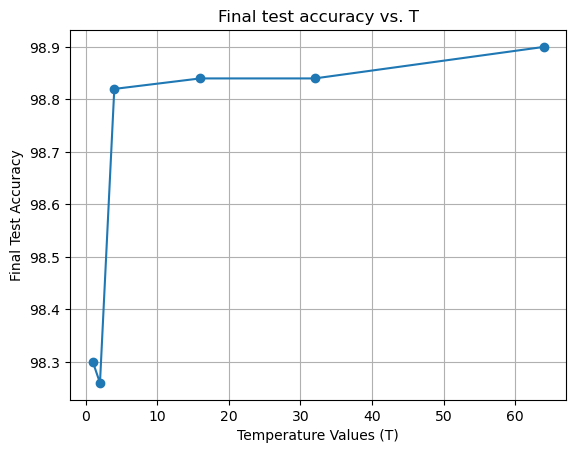

In [10]:
import matplotlib.pyplot as plt
plt.plot(T_vals, test_acc, '-o')
plt.xlabel('Temperature Values (T)')
plt.ylabel('Final Test Accuracy')
plt.title('Final test accuracy vs. T')
plt.grid()

# Problem 7 Train student from scratch

In [16]:
# Build fully connected student.
fc_model_no_distillation = tf.keras.Sequential()

# your code start from here for step 7
fc_model_no_distillation.add(tf.keras.layers.Flatten())
fc_model_no_distillation.add(tf.keras.layers.Dense(784,activation = 'relu'))
fc_model_no_distillation.add(tf.keras.layers.Dense(784,activation = 'relu'))
fc_model_no_distillation.add(tf.keras.layers.Dense(10))


#@test {"output": "ignore"}

def compute_plain_cross_entropy_loss(images, labels):
  """Compute plain loss for given images and labels.

  For fair comparison and convenience, this function also performs a
  LogSumExp over subclasses, but does not perform subclass distillation.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  # your code start from here for step 7

  student_subclass_logits = fc_model_no_distillation(images, training=True)
  cross_entropy_loss =  tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits( \
          labels, student_subclass_logits))

  return cross_entropy_loss

print('Training student model without KD')
train_and_evaluate(fc_model_no_distillation, compute_plain_cross_entropy_loss)

Training student model without KD
Epoch 1: Class_accuracy: 96.33%
Epoch 2: Class_accuracy: 97.42%
Epoch 3: Class_accuracy: 97.90%
Epoch 4: Class_accuracy: 97.92%
Epoch 5: Class_accuracy: 97.93%
Epoch 6: Class_accuracy: 97.77%
Epoch 7: Class_accuracy: 98.15%
Epoch 8: Class_accuracy: 98.24%
Epoch 9: Class_accuracy: 97.96%
Epoch 10: Class_accuracy: 98.01%
Epoch 11: Class_accuracy: 97.92%
Epoch 12: Class_accuracy: 98.14%


# Problem 8 Comparing the teacher and student model (number of of parameters and FLOPs)

In [12]:
# your code start from here for step 8
## https://github.com/tensorflow/tensorflow/issues/32809#issuecomment-849439287
from tensorflow.python.profiler.model_analyzer import profile
from tensorflow.python.profiler.option_builder import ProfileOptionBuilder
#print('TensorFlow:', tf.__version__)
def get_flops_number(model):
  forward_pass = tf.function(model.call,
      input_signature=[tf.TensorSpec(shape=(1,) + model.input_shape[1:])])

  graph_info = profile(forward_pass.get_concrete_function().graph,
                        options=ProfileOptionBuilder.float_operation())

  # The //2 is necessary since `profile` counts multiply and accumulate
  # as two flops, here we report the total number of multiply accumulate ops
  flops = graph_info.total_float_ops // 2
  return flops

In [13]:
# your code start from here for step 8
print('######### Teacher Model, Number of Parameters, Flops ################')
cnn_model.summary()
teacher_flops = get_flops_number(cnn_model)
print('Teacher Flops: {:,}'.format(teacher_flops))

print('######### Teacher Model, Number of Parameters, Flops ################')
fc_model.summary()
student_flops = get_flops_number(fc_model)
print('Students Flops: {:,}'.format(student_flops))

######### Teacher Model, Number of Parameters, Flops ################
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 25, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 23, 23, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 7744)              0         
                                                    

Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`


Teacher Flops: 11,021,029
######### Teacher Model, Number of Parameters, Flops ################
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_18 (Flatten)        (None, 784)               0         
                                                                 
 dense_53 (Dense)            (None, 784)               615440    
                                                                 
 dense_54 (Dense)            (None, 784)               615440    
                                                                 
 dense_55 (Dense)            (None, 10)                7850      
                                                                 
Total params: 1,238,730
Trainable params: 1,238,730
Non-trainable params: 0
_________________________________________________________________
Students Flops: 1,237,941


# Implementing the state-of-the-art KD algorithm

Please, check file Task1p12.ipynb for the implementation

# XAI method to explain models

In [14]:
# your code start from here for step 13
